# Fashion-MNIST Classification using Neural Network

In this notebook, we'll build a neural network to classify Fashion-MNIST images

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
import lightning.pytorch as pl

In [2]:
# Download training and testing data
class FMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = '.', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dims = (1, 28, 28)
        self.n_classes = 10
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.RandomHorizontalFlip(),
        ])
    
    def prepare_data(self):
        FashionMNIST(self.data_dir, train=False, download=True)
        FashionMNIST(self.data_dir, train=True, download=True)

    def setup(self, stage: str):
        if stage == "fit":
            fmnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = random_split(fmnist_full, [55000, 5000])
        if stage == "test":
            self.fmnist_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)
        if stage == "predict":
            self.fmnist_predict = FashionMNIST(self.data_dir, train=False, transform=self.transform)
        

    def train_dataloader(self):
        return DataLoader(self.fmnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=self.batch_size)
    
    def predict_dataloader(self):
        return DataLoader(self.fmnist_predict, batch_size=self.batch_size)

In [ ]:
dm = FMNISTDataModule()
dm.prepare_data()
dm.setup("fit")

torch.Size([1, 28, 28]) torch.Size([32])
Bag


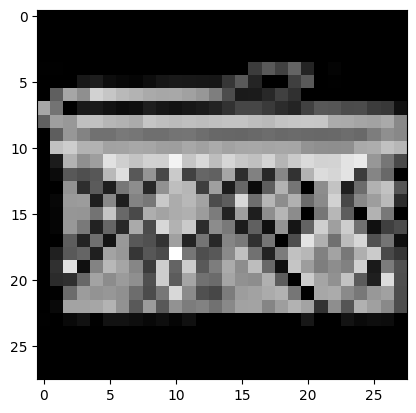

In [5]:
image, label = next(iter(dm.train_dataloader()))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

## Build the network

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(OrderedDict([
            ('bn', nn.BatchNorm2d(1)),
            ('conv1', nn.Conv2d(1, 64, 5, 1, 2)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2)),
            ('dropout1', nn.Dropout(0.1)),
            ('conv2', nn.Conv2d(64, 64, 5, 1, 2)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2)),
            ('dropout2', nn.Dropout(0.3)),
        ]))
        self.linear_layers = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(64 * 7 * 7, 256)),
            ('relu3', nn.ReLU()),
            ('dropout1', nn.Dropout(0.5)),
            ('fc2', nn.Linear(256, 64)),
            ('relu4', nn.ReLU()),
            ('bn2', nn.BatchNorm1d(64)),
            ('fc3', nn.Linear(64, 10)),
            ('logsoftmax', nn.LogSoftmax(1)),
        ]))

        for m in self.conv_layers:
            if isinstance(m, nn.Conv2d):
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
            if isinstance(m, nn.BatchNorm2d):
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)
        for m in self.linear_layers:
            if isinstance(m, nn.BatchNorm2d):
                torch.nn.init.normal_(m.weight, 0.0, 0.02)
                torch.nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.Linear):
                size = m.weight.size()
                fan_out = size[0]
                fan_in = size[1]
                variance = np.sqrt(2.0/(fan_in + fan_out))
                m.weight.data.normal_(0.0, variance)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
class LitModel(pl.LightningModule):
    def __init__(self, cnn, optimizer, lr):
        super().__init__()
        self.model = cnn
        self.optimizer = optimizer
        self.lr = lr
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        self.log("val_loss", loss)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics
    
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torch.sum(torch.argmax(y_hat, 1) == y) / len(y)
        return loss, acc
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        if self.optimizer == 'adam':
            optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == 'sgd':
            optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        else:
            optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        return optimizer

## Train the network

In [10]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("classification_logs")

In [11]:
epochs = 3
lr = 0.0007
optimizer = 'adam'
batch_size = 32
data_dir = '.'

model = LitModel(CNN(), optimizer, lr)

dm = FMNISTDataModule(data_dir=data_dir, batch_size=batch_size)
dm.prepare_data()
dm.setup("fit")

trainer = pl.Trainer(accelerator="auto", max_epochs=epochs, logger=logger)
trainer.fit(model=model, datamodule=dm)

dm.setup('test')
trainer.test(model=model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: classification_logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 924 K 
-------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.698     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\javid\AppData\Local\Programs\Python\Python37\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
c:\Users\javid\AppData\Local\Programs\Python\Python37\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\javid\AppData\Local\Programs\Python\Python37\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.882099986076355     │
│         test_loss         │    0.31841665506362915    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.882099986076355, 'test_loss': 0.31841665506362915}]

In [9]:
torch.save(trainer.model.state_dict(), f"checkpoints/cnn_{optimizer}_{epochs}e.pth")